In [1]:
import pickle
import matplotlib.pyplot as plt 

import numpy as np

import torch
from torch import nn

from torchdiffeq import odeint

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Load the data

In [3]:
# load the data from the file

noise_level = '0_1'
noise_scale = 0.1
with open('train_traj_noise' + str(noise_level) + '.p', 'rb') as f:
    train_data = pickle.load(f)

with open('test_traj_noise' + str(noise_level) + '.p', 'rb') as f:
    test_data = pickle.load(f)


In [4]:
X_train = train_data['obs']
X_test = test_data['obs']

time_train = train_data['time']
time_test = test_data['time']

X_train.shape, X_test.shape

((5001, 40), (5001, 40))

In [5]:
K = 40  # Number of globa-scale variables X
J = 5  # Number of local-scale Y variables per single global-scale X variable
nt = 5000  # Number of time steps
si = 0.2  # Sampling time interval
dt = 0.005  # Time step
F = 8.0  # Forcing
h = 1.0  # Coupling coefficient
b = 10.0  # ratio of amplitudes
c = 10.0  # time-scale ratio

k = np.arange(K)  # For coordinate in plots
j = np.arange(J * K)  # For coordinate in plots

In [6]:
localize = True
localization_lengthscale = 20
localization_matrix = np.zeros((K,K))
for i in range(K):
    for j in range(K):
        localization_matrix[i,j] = np.exp(-abs(i-j)**2 / localization_lengthscale)

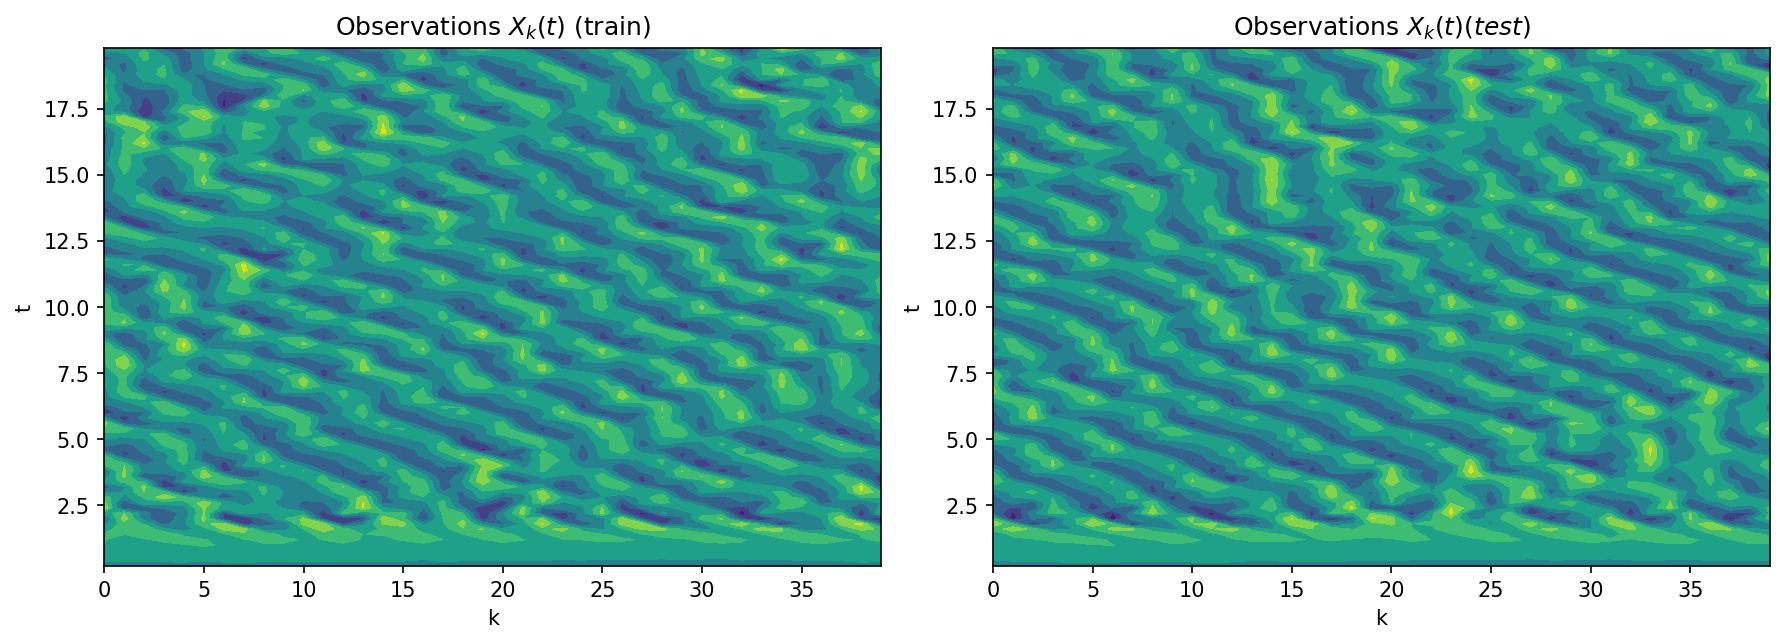

In [7]:
plt.figure(figsize=(12, 8), dpi=150)

time_cutoff = 100


# True X
plt.subplot(221)
plt.contourf(k, time_train[1:time_cutoff], X_train[1:time_cutoff])
plt.xlabel("k")
plt.ylabel("t")
plt.title("Observations $X_k(t)$ (train)")

# True X
plt.subplot(222)
plt.contourf(k, time_test[1:time_cutoff], X_test[1:time_cutoff])
plt.xlabel("k")
plt.ylabel("t")
plt.title("Observations $X_k(t) (test)$")

plt.tight_layout()
plt.show()

# Integrate using torchdiffeq

In [8]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

In [9]:
def L96_eq1_xdot(t, X, F = F, advect=True):
    """
    Calculate the time rate of change for the X variables for the Lorenz '96, equation 1:
        d/dt X[k] = -X[k-2] X[k-1] + X[k-1] X[k+1] - X[k] + F

    Args:
        X : Values of X variables at the current time step
        F : Forcing term
    Returns:
        dXdt : Array of X time tendencies
    """

    K = len(X)
    Xdot = torch.zeros(K)

    if advect:
        Xdot = torch.roll(X, 1) * (torch.roll(X, -1) - torch.roll(X, 2)) - X + F
    else:
        Xdot = -X + F
    #     for k in range(K):
    #         Xdot[k] = ( X[(k+1)%K] - X[k-2] ) * X[k-1] - X[k] + F
    return Xdot

In [10]:
N_particles = 50
model_noise = 0.1
particles = X_train[0] + 0.1 * torch.normal(mean=0, std=1.0, size = (N_particles, K))

In [11]:
odeint(L96_eq1_xdot, particles, torch.tensor([0.0, dt]), method='rk4').shape

torch.Size([2, 50, 40])

In [12]:
# Define our neural network model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(K, 4*K),
            nn.ReLU(),
            nn.Linear(4*K, 4*K),
            nn.ReLU(),
            nn.Linear(4*K, K),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [13]:
model = NeuralNetwork()

In [14]:
model(particles).shape, odeint(L96_eq1_xdot, particles, torch.tensor([0.0, dt]), method='rk4')[-1].shape

(torch.Size([50, 40]), torch.Size([50, 40]))

In [15]:
localization_matrix = torch.tensor(localization_matrix, dtype=torch.float32)

In [16]:
noise_scale = 0.1

In [17]:
def estimate_log_likelihood(model, particles, y_obs, dt, noise_scale, model_noise):
    nt = y_obs.shape[0]
    log_est = torch.tensor([0.0])
    for i in range(nt):
        # propagate particles one step forward
        pred = odeint(L96_eq1_xdot, particles, torch.tensor([0.0, dt]), method='rk4')[-1] + model(particles) + torch.normal(mean=0, std=model_noise, size = (N_particles, K))

        #Compute the empirical covariance matrix
        cov = torch.cov(pred.T)
        mean = torch.mean(pred, axis=0)
        
        if localize:
            cov = localization_matrix * cov
        y = y_obs[i]
        
        # Draw observational noise and correct the particles
        noise = torch.normal(mean = 0.0, std=noise_scale, size=particles.shape)
        increment = y - noise - pred
        correction = cov@torch.linalg.solve(cov + (noise_scale**2)*torch.eye(K), increment.T)
        
        particles = pred + correction.T

        # Compute the log-likelihood
        diff = y - mean
        log_est += -0.5 * torch.linalg.solve(cov + (noise_scale**2)*torch.eye(K), diff.T).T@diff.T
    return log_est/nt/K

In [18]:
estimate_log_likelihood(model, particles, X_train[:20], dt, noise_scale, model_noise)

/tmp/ipykernel_865488/2520398572.py:25: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343970094/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  log_est += -0.5 * torch.linalg.solve(cov + (noise_scale**2)*torch.eye(K), diff.T).T@diff.T


tensor([-199.4080], grad_fn=<DivBackward0>)

# AutoDiff ENKF

In [91]:
train_length = 100
n_seq = X_train.shape[0] // train_length
print(n_seq)

number_of_epochs = 4
loss_hist = []

50


In [92]:
model = NeuralNetwork()
# Initialize the optimizer to be adam
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

In [93]:
for epoch in range(number_of_epochs):
    for i in range(n_seq):
        
        # Extract a sub-sequence
        X_seq = X_train[i*train_length: (i+1)*train_length]
        # Define the initial condition
        particles = X_seq[0] + model_noise * torch.normal(mean=0, std=1.0, size = (N_particles, K))
        # Define the observations
        y_seq = X_seq[1:]

        
        optimizer.zero_grad()
        loss = -estimate_log_likelihood(model, particles, y_seq, dt, noise_scale, model_noise)
        loss.backward()
        optimizer.step()
        loss_hist.append(loss.item())
        print(f"Epoch {epoch}, Iteration {i}, Loss {loss.item()}")

Epoch 0, Iteration 0, Loss 194.4995574951172
Epoch 0, Iteration 1, Loss 192.0164794921875
Epoch 0, Iteration 2, Loss 190.51217651367188
Epoch 0, Iteration 3, Loss 185.84115600585938
Epoch 0, Iteration 4, Loss 181.86538696289062
Epoch 0, Iteration 5, Loss 184.4438934326172
Epoch 0, Iteration 6, Loss 180.5400848388672
Epoch 0, Iteration 7, Loss 178.4287109375
Epoch 0, Iteration 8, Loss 178.22596740722656
Epoch 0, Iteration 9, Loss 181.11569213867188
Epoch 0, Iteration 10, Loss 173.2071533203125
Epoch 0, Iteration 11, Loss 161.94363403320312
Epoch 0, Iteration 12, Loss 169.51089477539062
Epoch 0, Iteration 13, Loss 176.95901489257812
Epoch 0, Iteration 14, Loss 168.56532287597656
Epoch 0, Iteration 15, Loss 160.2084503173828
Epoch 0, Iteration 16, Loss 158.05711364746094
Epoch 0, Iteration 17, Loss 147.85214233398438
Epoch 0, Iteration 18, Loss 156.56260681152344
Epoch 0, Iteration 19, Loss 155.83436584472656
Epoch 0, Iteration 20, Loss 154.48428344726562
Epoch 0, Iteration 21, Loss 154.6

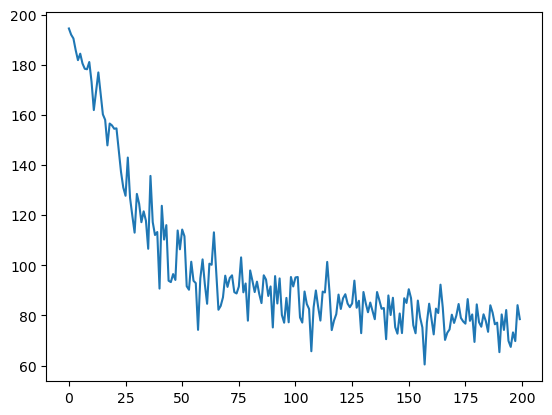

In [94]:
plt.plot(loss_hist)

# Predict on the testing trajectory

In [97]:
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=40, out_features=160, bias=True)
    (1): ReLU()
    (2): Linear(in_features=160, out_features=160, bias=True)
    (3): ReLU()
    (4): Linear(in_features=160, out_features=40, bias=True)
  )
)

In [98]:
prediction_test = []
analysis_test = []
correction_test = []

particles_test =  X_test[0] + model_noise * torch.normal(mean=0, std=1.0, size = (N_particles, K))

In [99]:
for i in range(time_test.shape[0]-1):
    # propagate particles one step forward
    pred = odeint(L96_eq1_xdot, particles_test, torch.tensor([0.0, dt]), method='rk4')[-1] + model(particles_test) + torch.normal(mean=0, std=model_noise, size = (N_particles, K))

    #Compute the empirical covariance matrix
    cov = torch.cov(pred.T)
    mean = torch.mean(pred, axis=0)
    
    if localize:
        cov = localization_matrix * cov
    y = X_test[i+1]
    
    # Draw observational noise and correct the particles
    noise = torch.normal(mean = 0.0, std=noise_scale, size=particles.shape)
    increment = y - noise - pred
    correction = cov@torch.linalg.solve(cov + (noise_scale**2)*torch.eye(K), increment.T)
    
    particles = pred + correction.T

    prediction_test.append(pred)
    analysis_test.append(particles)
    correction_test.append(correction)
    
analysis_test = torch.stack(analysis_test)
prediction_test = torch.stack(prediction_test)
correction_test = torch.stack(correction_test)

analysis_test= analysis_test.detach().numpy()
prediction_test = prediction_test.detach().numpy()
correction_test = correction_test.detach().numpy()


In [100]:
np.mean((np.mean(analysis_test, axis = 1) - X_test[1:].detach().numpy())**2)

2.155279

In [101]:
np.mean((np.mean(prediction_test, axis = 1) - X_test[1:].detach().numpy())**2)

15.465237

In [75]:
# Without the NN

prediction_vanilla = []
analysis_vanilla = []
correction_vanilla = []

particles_vanilla =  X_test[0] + model_noise * torch.normal(mean=0, std=1.0, size = (N_particles, K))

In [77]:
for i in range(time_test.shape[0]-1):
    # propagate particles one step forward
    pred = odeint(L96_eq1_xdot, particles_vanilla, torch.tensor([0.0, dt]), method='rk4')[-1]  + torch.normal(mean=0, std=model_noise, size = (N_particles, K))

    #Compute the empirical covariance matrix
    cov = torch.cov(pred.T)
    #mean = torch.mean(pred, axis=0)
    
    if localize:
        cov = localization_matrix * cov
    y = X_test[i+1]
    
    # Draw observational noise and correct the particles
    noise = torch.normal(mean = 0.0, std=noise_scale, size=particles.shape)
    increment = y - noise - pred
    
    correction = cov@torch.linalg.solve(cov + (noise_scale**2)*torch.eye(K), increment.T)
    
    particles_vanilla = pred + correction.T

    prediction_vanilla.append(pred)
    analysis_vanilla.append(particles_vanilla)
    correction_vanilla.append(correction)
    
analysis_vanilla= torch.stack(analysis_vanilla)
prediction_vanilla = torch.stack(prediction_vanilla)
correction_vanilla = torch.stack(correction_vanilla)

analysis_vanilla= analysis_vanilla.detach().numpy()
prediction_vanilla= prediction_vanilla.detach().numpy()
correction_vanilla = correction_vanilla.detach().numpy()


In [78]:
np.mean((np.mean(analysis_vanilla, axis = 1) - X_test[1:].detach().numpy())**2)

3.802708

In [79]:
np.mean((np.mean(prediction_vanilla, axis = 1) - X_test[1:].detach().numpy())**2)

10.677876

# 